In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/sur/src/" /content
!cp -r "/content/drive/MyDrive/Colab Notebooks/sur/data/" /content

In [2]:
import sys
sys.path.append('.')

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import os

import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset
print(torch.__version__)

from src.dataset import ImageDataset
from src.config import Config

cfg = Config()

2.2.2+cu121
Mean: [0.51393522 0.39408562 0.4046115 ], Std: [0.21051145 0.21676759 0.20957546]


In [4]:
# Training dataset
train_dataset = ImageDataset(root_dir=cfg.DATA_DIR, train=True, transform=cfg.TRANSFORM_TRAIN)
# Testing/validation dataset
test_dataset = ImageDataset(root_dir=cfg.DATA_DIR, train=False, transform=cfg.TRANSFORM_TEST)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 151
Number of testing samples: 70


In [5]:
from torch.utils.data import DataLoader

# no num_workers or some weird stuff
train_dataloader_display = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
test_dataloader_display = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

Feature batch shape: torch.Size([1, 3, 80, 80])
Labels batch shape: torch.Size([1])
Label: 0


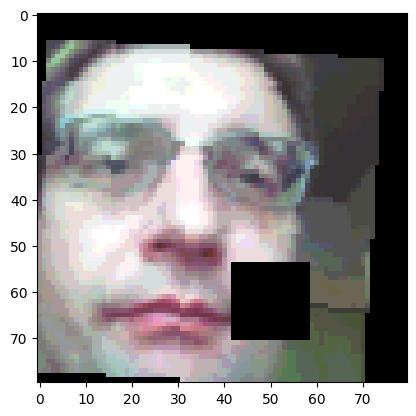

In [5]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader_display))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
print(f"Label: {label}")
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [6]:
# no num_workers or some weird stuff
train_dataloader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, pin_memory=True)

In [9]:
from torch.optim import SGD, Adam
from src.models.resnet9 import ResNet9

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #- mx250 throwing bsod (:

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
else:
    print('Using CPU')

model = ResNet9(3, cfg.NUM_CLASSES).to(device)
optimizer_sgd = SGD(model.parameters(), lr=cfg.MAX_LR, momentum=cfg.MOMENTUM, weight_decay=cfg.WEIGHT_DECAY, nesterov=cfg.NESTEROV)

NVIDIA GeForce MX250


In [11]:
from src.trainmodel import train

print(f"Training on {len(train_dataset)} samples and validating on {len(test_dataset)} samples")
history, best_model_w, best_epoch = train(model, train_dataloader, test_dataloader, cfg.EPOCHS, optimizer_sgd,
       device, cfg, grad_clip=cfg.GRAD_CLIP, verbose=True)

Training on 151 samples and validating on 70 samples
[Epoch: 01/569] - 0.58s | LR: 0.000012 | Train Loss: 0.0606 | Train Acc: 96.52 | Test Loss: 0.0385 | Test Acc: 98.57
[Epoch: 02/569] - 0.55s | LR: 0.000012 | Train Loss: 0.0270 | Train Acc: 99.37 | Test Loss: 0.0431 | Test Acc: 97.14
[Epoch: 03/569] - 0.56s | LR: 0.000012 | Train Loss: 0.0364 | Train Acc: 98.75 | Test Loss: 0.0416 | Test Acc: 97.14
[Epoch: 04/569] - 0.54s | LR: 0.000012 | Train Loss: 0.0288 | Train Acc: 98.57 | Test Loss: 0.0557 | Test Acc: 97.14
[Epoch: 05/569] - 0.54s | LR: 0.000012 | Train Loss: 0.0458 | Train Acc: 99.37 | Test Loss: 0.0670 | Test Acc: 95.71
[Epoch: 06/569] - 0.57s | LR: 0.000012 | Train Loss: 0.0384 | Train Acc: 98.12 | Test Loss: 0.0450 | Test Acc: 97.14
[Epoch: 07/569] - 0.53s | LR: 0.000012 | Train Loss: 0.0500 | Train Acc: 98.12 | Test Loss: 0.0403 | Test Acc: 98.57
[Epoch: 08/569] - 0.59s | LR: 0.000012 | Train Loss: 0.0335 | Train Acc: 100.00 | Test Loss: 0.0358 | Test Acc: 100.00
[Epoch: 0

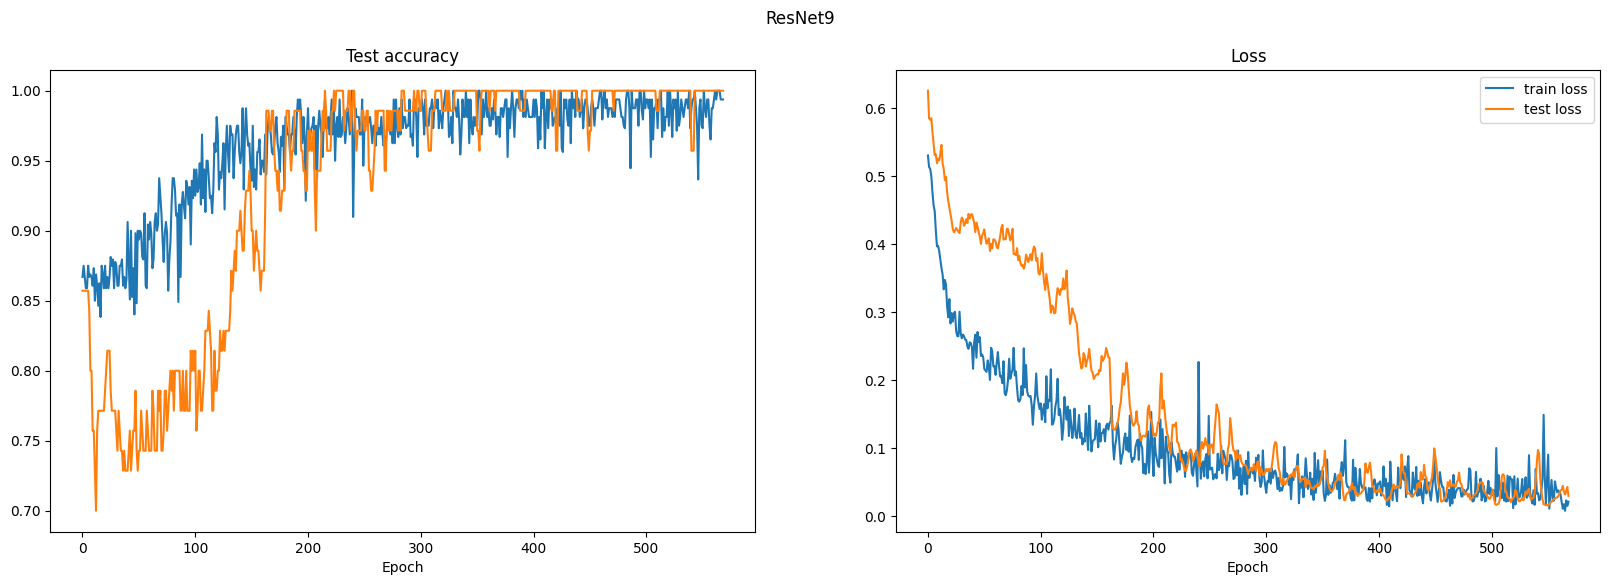

In [85]:
from src.utils import plot_graphs

plot_graphs(history, "ResNet9")

In [29]:
# save model
from src.trainmodel import save_model
gdrive_path = '/content/drive/MyDrive/Colab Notebooks/sur/checkpoints/'

model.load_state_dict(best_model_w)
save_model(model, optimizer_sgd, cfg.EPOCHS, gdrive_path+f"img_model-ResNet9-{best_epoch}e", history)

### Trained models on collab
- resnet9
- preact_resnet18

In [12]:
from src.trainmodel import load_model

device = torch.device('cpu')

_, _, _, history_resnet9_1 = load_model("checkpoints/img_model-ResNet9-569e.model", device=device)
_, _, _, history_resnet9_2 = load_model("checkpoints/img_model-ResNet9-1103e.model", device=device)
model_state_dict_resnet9, _, _, history_resnet9_3 = load_model("checkpoints/img_model-ResNet9-1173e.model", device=device) # best model for resnet9
_, _, _, history_preactresnet18_1 = load_model("checkpoints/img_model-PreAct-ResNet18-361e.model", device=device)
model_state_dict_preactresnet18, _, _, history_preactresnet18_2 = load_model("checkpoints/img_model-PreAct-ResNet18-404e.model", device=device)
# model_state_dict_preactresnet18, _, _, history_preactresnet18_3 = load_model("checkpoints/img_model-PreAct-ResNet18-471e.model") # best model for preactresnet18

# combine the histories
history_resnet9 = history_resnet9_1 + history_resnet9_2 + history_resnet9_3
history_preactresnet18 = history_preactresnet18_1 + history_preactresnet18_2 #+ history_preactresnet18_3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


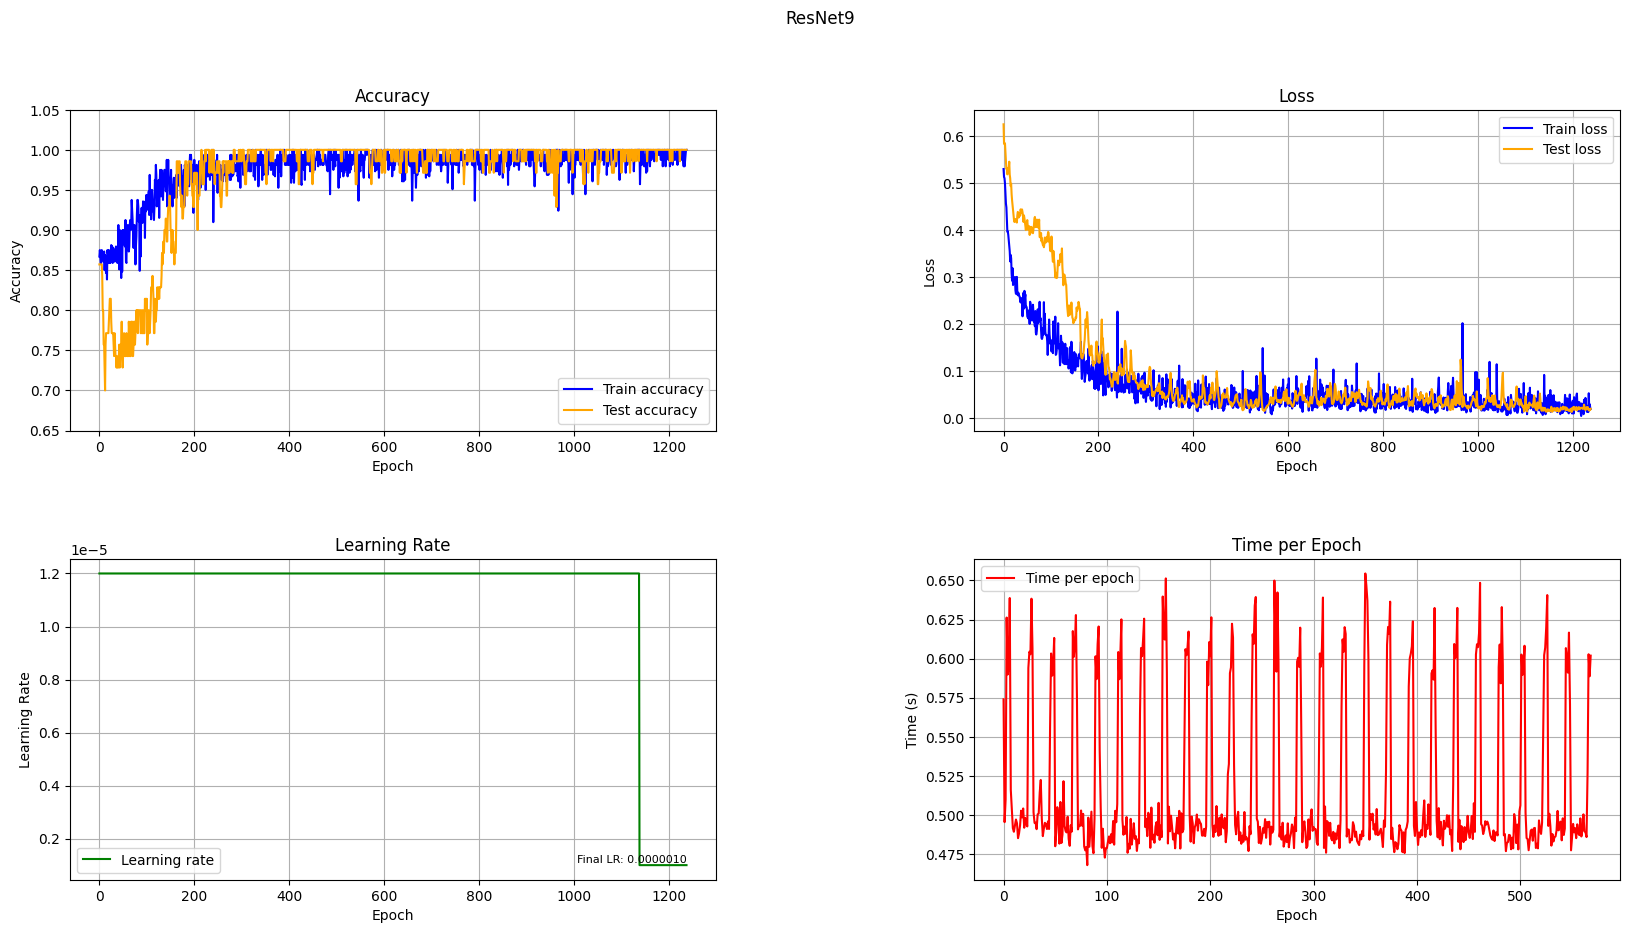

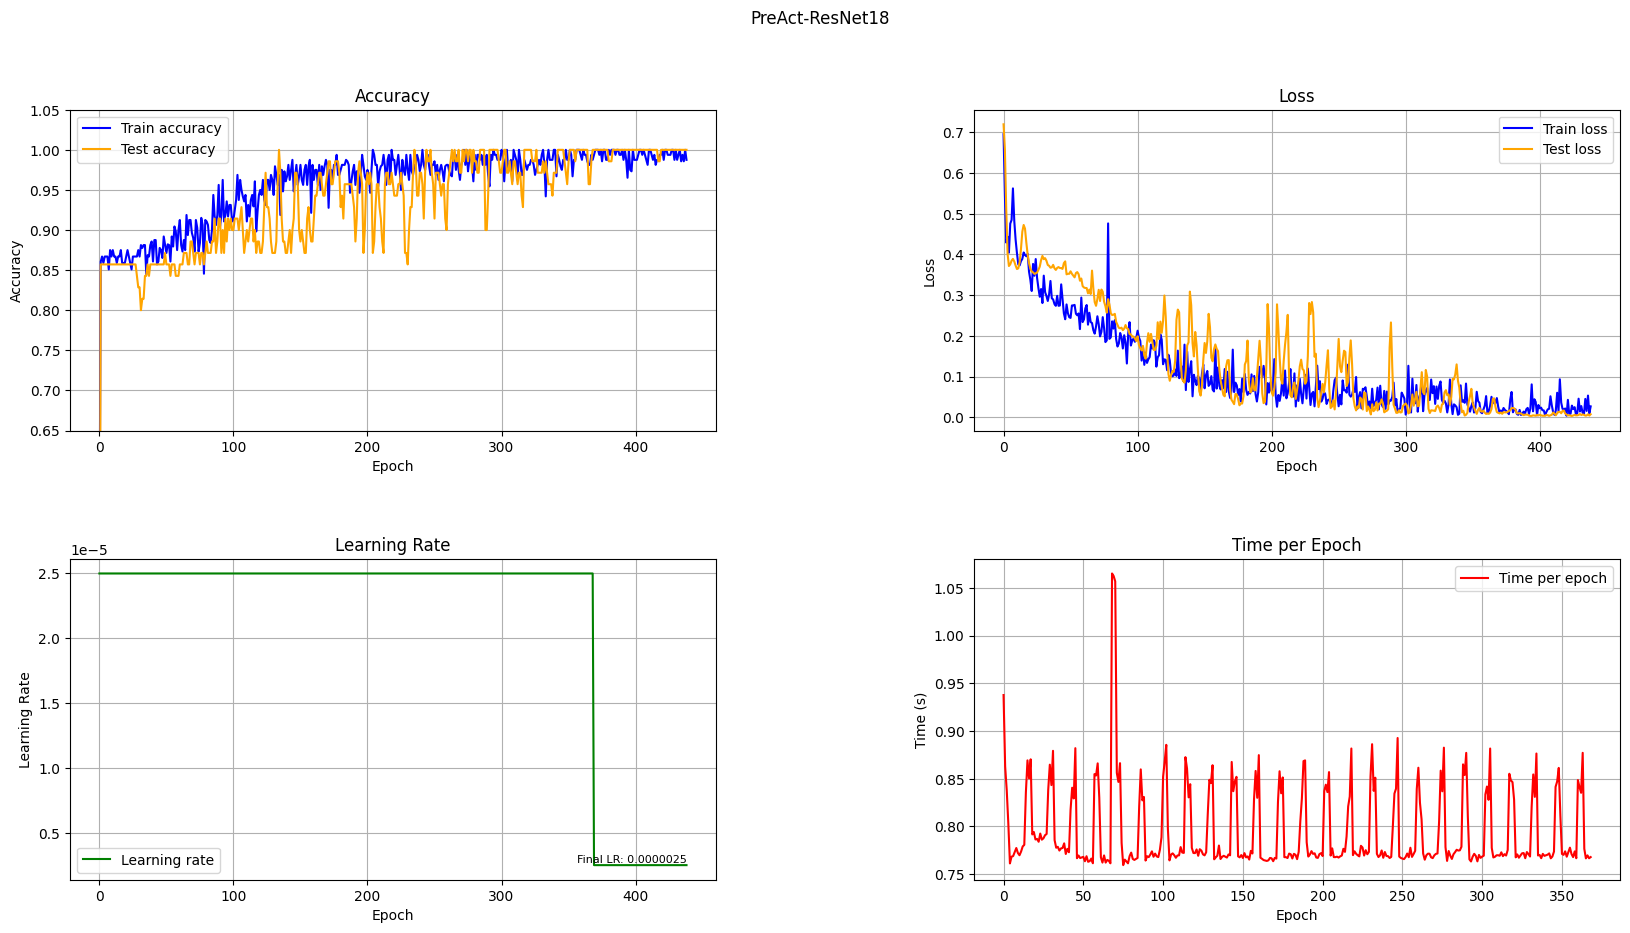

In [13]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
# plot the graphs
from src.utils import plot_graphs

plot_graphs(history_resnet9, "ResNet9")
plot_graphs(history_preactresnet18, "PreAct-ResNet18")

In [14]:
# get predictions from test_dataloader_display
from src.models.resnet9 import ResNet9
from src.models.preact_resnet import PreActResNet18
from src.trainmodel import evaluate


device = torch.device('cpu')

model_resnet9 = ResNet9(3, cfg.NUM_CLASSES)
model_resnet9.load_state_dict(model_state_dict_resnet9)

model_preactresnet18 = PreActResNet18()
model_preactresnet18.load_state_dict(model_state_dict_preactresnet18)

criterion = torch.nn.CrossEntropyLoss()
model_resnet9.to(device)
model_preactresnet18.to(device)
criterion.to(device)

# print number of params for models
print(f"Number of parameters for ResNet9: {model_resnet9.count_parameters()}")
print(f"Number of parameters for PreActResNet18: {model_preactresnet18.count_parameters()}")

Number of parameters for ResNet9: 6571266
Number of parameters for PreActResNet18: 11167042


In [15]:
test_loss_resnet9, test_acc_resnet9 = evaluate(model_resnet9, test_dataloader, device, criterion)
train_loss_resnet9, train_acc_resnet9 = evaluate(model_resnet9, train_dataloader, device, criterion)

test_loss_preactresnet18, test_acc_preactresnet18 = evaluate(model_preactresnet18, test_dataloader, device, criterion)
train_loss_preactresnet18, train_acc_preactresnet18 = evaluate(model_preactresnet18, train_dataloader, device, criterion)

In [16]:
print(f"[ResNet9]           - Test Loss: {test_loss_resnet9:.4f}, Test Acc: {test_acc_resnet9:.4f}, Train Loss: {train_loss_resnet9:.4f}, Train Acc: {train_acc_resnet9:.4f}")
print(f"[Preact ResNet18]   - Test Loss: {test_loss_preactresnet18:.4f}, Test Acc: {test_acc_preactresnet18:.4f}, Train Loss: {train_loss_preactresnet18:.4f}, Train Acc: {train_acc_preactresnet18:.4f}")

[ResNet9]           - Test Loss: 0.0191, Test Acc: 1.0000, Train Loss: 0.0117, Train Acc: 1.0000
[Preact ResNet18]   - Test Loss: 0.0077, Test Acc: 1.0000, Train Loss: 0.0040, Train Acc: 1.0000


In [34]:
# Evaluate model on eval data without labels "data/eval/*.png"
# The results file will be ASCII with three fields separated per line
# gap. These fields will contain the following data in order:

#   - segment name (file name without .wav or .png extension)
#   - numerical score, the higher the value, the more certain the system is that it is the wanted person
#   - hard decision: number 1 for the wanted person otherwise 0. Make this decision assuming that the a priori probability of the wanted person appearing in each tested pattern is 0.5.
data_eval = []
for file in os.listdir("./data/eval"):
    if file.endswith(".png"):
        img = Image.open(f"data/eval/{file}")
        # change to RGB
        img = img.convert("RGB")
        img = cfg.TRANSFORM_TEST(img)
        data_eval.append((file[:-4], img))

In [55]:
# Run the model on the eval data
output_pred_r9 = []
output_pred_pr18 = []
lenght = len(data_eval)
with torch.no_grad():
    model_resnet9.eval()
    model_preactresnet18.eval()
    i = 0
    for name, img in data_eval:
        img = img.unsqueeze(0).to(device)
        output_resnet9 = model_resnet9(img)
        output_preactresnet18 = model_preactresnet18(img)
        tmp_r9 = f"{name} {output_resnet9[0][1].item()} {output_resnet9.max(1)[1].item()}"
        tmp_pr18 = f"{name} {output_preactresnet18[0][1].item()} {output_preactresnet18.max(1)[1].item()}"
        output_pred_r9.append(tmp_r9)
        output_pred_pr18.append(tmp_pr18)
        # every 250 img print
        if i % 250 == 0:
            print(f"Processed {i}/{lenght}")
        i = i + 1



Processed 0/1342
Processed 250/1342
Processed 500/1342
Processed 750/1342
Processed 1000/1342
Processed 1250/1342


In [63]:
# save the results
with open("./data/results/image_resnet9", "wb") as f:
    for line in output_pred_r9:
        line_ascii = (line+ "\n").encode("ascii")
        f.write(line_ascii)

with open("./data/results/image_preactresnet18", "wb") as f:
    for line in output_pred_pr18:
        line_ascii = (line+ "\n").encode("ascii")
        f.write(line_ascii)